In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re, os, math, random
from collections import Counter
from collections import defaultdict
import operator
from tqdm import tqdm
import jieba
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack
from nltk.stem import SnowballStemmer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding, Bidirectional, CuDNNGRU, CuDNNLSTM, Conv1D, GlobalMaxPooling1D
from keras.layers.merge import concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
from tensorflow.python.ops import tensor_array_ops, control_flow_ops
import gc

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Parameters

In [2]:
jieba.enable_parallel(8)
train_corpus = "train_first.csv"
test_corpus = "predict_first.csv"
vocab_path = "Chinese_corpus_dict.vocab"
clean_stop_word = False
vocab_size = 20000
embedding_dims = 300
seq_length = 100
pointer = 0

#####################
## Text RNN
rnn_recurrent_units = 48
rnn_dense_units = 32
rnn_output_units = 5
rnn_batch_size = 256
#####################

#####################
## Text CNN
cnn_filter_nums = 120
cnn_dense_units = 72
cnn_output_units = 5
cnn_batch_size = 256
#####################

#####################
## Hybrid Text NN
hy_recurrent_units = 48
hy_filter_nums = 64
hy_output_units = 5
hy_batch_size = 256
#####################

#####################
## Seq2seq
seq_batch_size = 50
enc_hidden_size = 150
dec_hidden_size = 300
seq_learning_rate = 0.01
start_word = 2    # token number of <SOS>
train_epochs = 10
dropout_keep_prob = 0.75
l2_reg_lambda = 0.2
seq_label_size = 5
#####################

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.580 seconds.
Prefix dict has been built succesfully.


# Data Analysis

In [3]:
train_df = pd.read_csv(train_corpus)
test_df = pd.read_csv(test_corpus)

# train_df.sample(100)
train_df.head()

,Id,Discuss,Score
0,201e8bf2-77a2-3a98-9fcf-4ce03914e712,好大的一个游乐公园，已经去了2次，但感觉还没有玩够似的！会有第三，第四次的,5
1,f4d51947-eac4-3005-9d3c-2f32d6068a2d,新中国成立也是在这举行，对我们中国人来说有些重要及深刻的意义！,4
2,74aa7ae4-03a4-394c-bee0-5702d3a3082a,庐山瀑布非常有名，也有非常多个瀑布，只是最好看的非三叠泉莫属，推荐一去,4
3,099661c2-4360-3c49-a2fe-8c783764f7db,个人觉得颐和园是北京最值的一起的地方，不过相比下门票也是最贵的，比起故宫的雄伟与气势磅礴，颐...,5
4,97ca672d-e558-3542-ba7b-ee719bba1bab,迪斯尼一日游,5


# ------------------------------

In [ ]:
# some test for iloc & drop
train_af = train_df.drop(train_df[train_df.Discuss == '好大的一个游乐公园，已经去了2次，但感觉还没有玩够似的！会有第三，第四次的'].index, axis=0)

In [ ]:
train_af = train_df.drop([0,1,2], axis=0)

In [ ]:
train_af.head()

# --------------------------------

In [4]:
label_cols = pd.unique(train_df['Score'])
print(label_cols)

[5 4 3 2 1]


In [5]:
train_df.describe()

,Score
count,100000.000000
mean,4.470010
std,0.752134
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [6]:
test_df.head()

,Id,Discuss
0,9a1caf96-681e-3c11-b588-43ac742d7fd2,快乐之旅
1,82b450db-65c2-351c-84fb-761d76582680,岛上看日落的地方，视野很开阔，非常漂亮
2,2eec4606-590c-3fa2-b846-7f92441c54a6,很有鲁迅风味 很喜欢这样有文化的地方
3,509f9a68-ac41-35ff-9d2e-2fc12f73ed7f,去乌鲁木齐还能不去天山天池吗，哈哈哈～
4,395f4b22-1c5f-328a-a19d-5065e0530cbc,非常满意，直接拿身份证刷机入园就行了，不用排队买票，比较节约时间


In [7]:
# Data length
print("Total rows in train_corpus is {}".format(len(train_df)))
print("Total rows in test_corpus is {}".format(len(test_df)))
print(train_df['Score'].value_counts())

Total rows in train_corpus is 100000
Total rows in test_corpus is 30000
5    60097
4    28954
3     9389
2      973
1      587
Name: Score, dtype: int64


In [8]:
# Sentence length analysis
train_df['Word_Length'] = train_df['Discuss'].apply(lambda x: len(str(x)))
train_df

,Id,Discuss,Score,Word_Length
0,201e8bf2-77a2-3a98-9fcf-4ce03914e712,好大的一个游乐公园，已经去了2次，但感觉还没有玩够似的！会有第三，第四次的,5,37
1,f4d51947-eac4-3005-9d3c-2f32d6068a2d,新中国成立也是在这举行，对我们中国人来说有些重要及深刻的意义！,4,31
2,74aa7ae4-03a4-394c-bee0-5702d3a3082a,庐山瀑布非常有名，也有非常多个瀑布，只是最好看的非三叠泉莫属，推荐一去,4,35
3,099661c2-4360-3c49-a2fe-8c783764f7db,个人觉得颐和园是北京最值的一起的地方，不过相比下门票也是最贵的，比起故宫的雄伟与气势磅礴，颐...,5,61
4,97ca672d-e558-3542-ba7b-ee719bba1bab,迪斯尼一日游,5,6
5,3b7f3f2e-886f-3a68-a810-2c37cfd728d3,方便,4,2
6,88914409-bd13-3d47-b5a2-691177dde8fd,看水看山都可以。感受古人的智慧结晶，秋景美丽如画，红黄绿相间！对于身体状况不佳的人来说，走平...,4,55
7,bf13ec92-6079-3451-ade3-88020cb0dcb5,赞,5,1
8,489c3d94-9c44-3cf2-949c-1b507c374c69,唯一糟点,5,4
9,285bba78-16a3-3c1d-b648-baa483883ee3,周未周边游,5,5


In [9]:
# print(train_df['Word_Length'].value_counts().head())

# For test_data
test_df['Word_Length'] = test_df['Discuss'].apply(lambda x: len(str(x)))
# print(test_df['Word_Length'].value_counts().head())
print(train_df['Word_Length'].describe(), "\n", test_df['Word_Length'].describe())

count    100000.000000
mean         48.283500
std          78.522278
min           1.000000
25%           9.000000
50%          24.000000
75%          52.000000
max        1336.000000
Name: Word_Length, dtype: float64 
 count    30000.000000
mean        49.249733
std         77.584046
min          1.000000
25%         11.000000
50%         25.000000
75%         54.000000
max       1136.000000
Name: Word_Length, dtype: float64


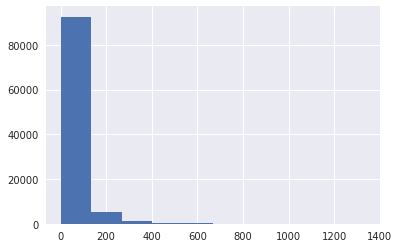

In [10]:
# histogram graph
sns.set()
train_df['Word_Length'].hist()
plt.show()

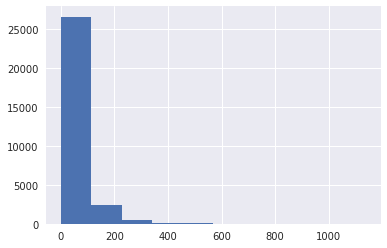

In [11]:
plt.figure()
plt.hist(test_df['Word_Length'])
plt.show()

In [12]:
train_df.sort_values('Word_Length', ascending=False).head(100)['Score'].value_counts()

5    56
4    31
3    12
1     1
Name: Score, dtype: int64

In [13]:
# transform to one-hot
Score = train_df['Score']
data = pd.get_dummies(Score)
train_df = pd.concat([train_df, data], axis=1)
train_df.head()

,Id,Discuss,Score,Word_Length,1,2,3,4,5
0,201e8bf2-77a2-3a98-9fcf-4ce03914e712,好大的一个游乐公园，已经去了2次，但感觉还没有玩够似的！会有第三，第四次的,5,37,0,0,0,0,1
1,f4d51947-eac4-3005-9d3c-2f32d6068a2d,新中国成立也是在这举行，对我们中国人来说有些重要及深刻的意义！,4,31,0,0,0,1,0
2,74aa7ae4-03a4-394c-bee0-5702d3a3082a,庐山瀑布非常有名，也有非常多个瀑布，只是最好看的非三叠泉莫属，推荐一去,4,35,0,0,0,1,0
3,099661c2-4360-3c49-a2fe-8c783764f7db,个人觉得颐和园是北京最值的一起的地方，不过相比下门票也是最贵的，比起故宫的雄伟与气势磅礴，颐...,5,61,0,0,0,0,1
4,97ca672d-e558-3542-ba7b-ee719bba1bab,迪斯尼一日游,5,6,0,0,0,0,1


## Get positive labels

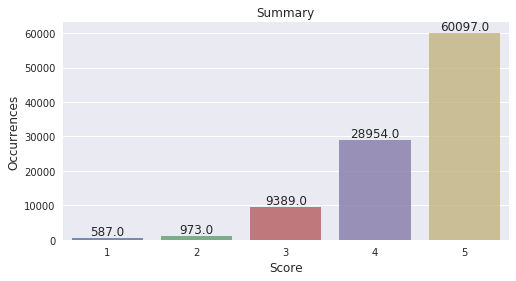

In [14]:
x = train_df.iloc[:, 4:].sum()

plt.figure(figsize=(8, 4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Summary")
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Score', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, ha='center', va='bottom', s='{:.1f}'.format(abs(label)))
    
plt.show()

## Correlations of labels

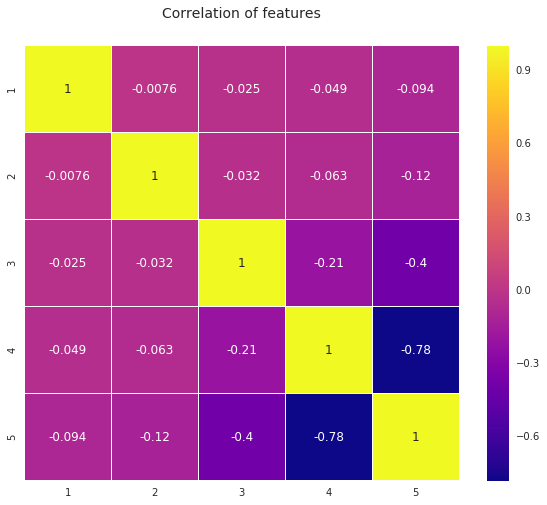

In [15]:
# No sentences contains up to 2 Score-labels
colormap = plt.cm.plasma
plt.figure(figsize=(10, 8))
plt.title('Correlation of features', y=1.05, size=14)
sns.heatmap(data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

# Processing

In [16]:
def clean_text(text, stem_words=False):
    text = re.sub(r',', '，', text)
    text = re.sub(r'\.+', '...', text)
    text = re.sub(r'\.{6}', '...', text)
    text = re.sub(r'…', '...', text)
    text = re.sub(r';', '；', text)
    text = re.sub(r'°', '。', text)
    text = re.sub(r'】', ']', text)
    text = re.sub(r'【', '[', text)
    text = re.sub(r'\)', '\）', text)
    text = re.sub(r'\(', '\（', text)
    text = re.sub(r'“', '"', text)
    text = re.sub(r' ', '', text)
    text = re.sub(r'”', '"', text)
    text = re.sub(r'～', '~', text)
    text = re.sub(r'·', '。', text)
    text = re.sub(r'!', '！', text)
    text = re.sub(r'—', '-', text)
    text = re.sub(r'》', '\）', text)
    text = re.sub(r'《', '\（', text)
    text = re.sub(r'\?', '\？', text)
    text = re.sub(r'。。。', '...', text)
    text = re.sub(r'。。。。。。', '...', text)
    text = re.sub(r':', '：', text)
    
#     # for English_sentence
#     text = replace_numbers.sub('', text)
#     text = special_character_removal.sub('', text)
#     if stem_words:
#         text = text.split()
#         stemmer = SnowballStemmer('english')
#         stemmed_words = [stemmer.stem(word) for word in text]
#         text = " ".join(stemmed_words)
    
    return text

# regex to remove all Non-Alpha Numeric and space
special_character_removal = re.compile(r'[^a-z\d ]', re.IGNORECASE)

# regex to remove all Alpha Numeric and space
special_alpha_removal = re.compile(r'[a-z\d ]', re.IGNORECASE)

# regex to replace all numeric
replace_numbers = re.compile(r'\d+', re.IGNORECASE)

In [17]:
# Check NaN
print(np.any(train_df.isnull()) == True, np.any(test_df.isnull()) == True)

False False


In [18]:
# Regular dictionary
print("MSG : Processing text datasets...")
cols_target = [1, 2, 3, 4, 5]

list_sentence_train = train_df['Discuss'].fillna("no discuss").values
train_discusses = [clean_text(text) for text in list_sentence_train]
train_df['Discuss'] = pd.Series(train_discusses).astype(str)

list_sentence_test = test_df['Discuss'].fillna("no discuss").values
test_discusses = [clean_text(text) for text in list_sentence_test]
test_df['Discuss'] = pd.Series(test_discusses).astype(str)

# cleaned_train_discuss = []
# for i in range(len(train_df)):
#     cleaned_discuss = clean_text(train_df['Discuss'][i])
#     cleaned_train_discuss.append(cleaned_discuss)
# train_df['Discuss'] = pd.Series(cleaned_train_discuss).astype(str)

# cleaned_test_discuss = []
# for i in range(len(test_df)):
#     cleaned_discuss = clean_text(test_df['Discuss'][i])
#     cleaned_test_discuss.append(cleaned_discuss)
# test_df['Discuss'] = pd.Series(cleaned_test_discuss).astype(str)
# test_df.head()

MSG : Processing text datasets...


In [19]:
# Clean up the sentence text & Word segmentation analysis
word_dict = defaultdict(int)

for sentence in tqdm(train_df['Discuss']):
    seg_list = jieba.cut(sentence, cut_all=False)
    for word in seg_list:
        word_dict[word] += 1
word_dict = sorted(word_dict.items(), key=operator.itemgetter(1), reverse=True)
print(len(word_dict))

100%|██████████| 100000/100000 [00:55<00:00, 1804.80it/s]

88384


In [20]:
cut_sentences = []
for sentence in tqdm(train_df['Discuss']):
    seg_list = jieba.cut(str(sentence), cut_all=False)
    cut_sentences.append(" ".join(seg_list))
train_df['Discuss_cut'] = cut_sentences

100%|██████████| 100000/100000 [00:58<00:00, 1701.17it/s]


In [21]:
cut_test_sentences = []
for sentence in tqdm(test_df['Discuss']):
    seg_list = jieba.cut(str(sentence), cut_all=False)
    cut_test_sentences.append(" ".join(seg_list))
test_df['Discuss_cut'] = cut_test_sentences

100%|██████████| 30000/30000 [00:15<00:00, 1902.43it/s]


In [22]:
train_data_cut = train_df['Discuss_cut'].values
test_data_cut = test_df['Discuss_cut'].values

## A quick view of vocabulary

In [23]:
chinese_list, sign_list, dig_english_list = [], [], []
for word, count in word_dict:
    for char in word:
        if char >= u'\u4E00' and char <= u"\u9FA5":
            chinese_list.append((word, count))
        elif (char >= u'\u0041' and char <= u'\u005A') or (char >= u'\u0061' and char <= u'\u007A') or (char >= u'\u0030' and char <= u'\u0039'):
            dig_english_list.append((word, count))
            break
        else:
            sign_list.append((word, count))
            break
sorted_dig_english_list = sorted(set(dig_english_list), key=lambda x: x[1], reverse=True)
sorted_sign_list = sorted(set(sign_list), key=lambda x: x[1], reverse=True)
sorted_chinese_list = sorted(set(chinese_list), key=lambda x: x[1], reverse=True)
print("chinese_word: ", len(sorted_chinese_list))
print("dig_english_word: ", len(sorted_dig_english_list))
print("sign_count: ", len(sorted_sign_list))
print(sorted_chinese_list[:10000], '\n\n', sorted_dig_english_list[:50], '\n\n', sorted_sign_list[:20])

chinese_word:  84768
dig_english_word:  3046
sign_count:  573
[('的', 161679), ('了', 43115), ('是', 42184), ('很', 30622), ('去', 26710), ('在', 24941), ('有', 22118), ('也', 17749), ('都', 16584), ('好', 14719), ('就', 14467), ('可以', 14124), ('不错', 13325), ('我', 12365), ('人', 11654), ('和', 11515), ('到', 11449), ('不', 10688), ('还', 9684), ('地方', 9463), ('景区', 9329), ('一个', 9325), ('就是', 8760), ('还是', 8362), ('非常', 8061), ('看', 8018), ('没有', 7675), ('要', 7669), ('很多', 7623), ('值得', 7557), ('上', 7371), ('这里', 7065), ('我们', 7010), ('景点', 6773), ('多', 6622), ('感觉', 6577), ('风景', 6565), ('来', 6194), ('时候', 5980), ('走', 5976), ('比较', 5561), ('但是', 5535), ('美', 5115), ('里面', 5058), ('景色', 4974), ('门票', 4828), ('真的', 4819), ('着', 4802), ('大', 4663), ('吧', 4586), ('看到', 4526), ('会', 4494), ('还有', 4459), ('从', 4360), ('你', 4327), ('说', 4176), ('没', 4144), ('元', 4034), ('不过', 3955), ('玩', 3924), ('北京', 3900), ('时间', 3888), ('但', 3805), ('特别', 3765), ('西湖', 3677), ('中', 3656), ('最', 3656), ('这', 3601), ('个'

In [24]:
# create stop words
chinese_stop_words = [word[0] for word in sorted_chinese_list[vocab_size - 24:]]
english_stop_words = [word[0] for word in sorted_dig_english_list]
sign_stop_words = [word[0] for word in sorted_sign_list[20:]]
stop_words = chinese_stop_words + english_stop_words + sign_stop_words
print(len(stop_words))

68391


In [25]:
train_df = train_df.drop('Word_Length', axis=1)
train_df

,Id,Discuss,Score,1,2,3,4,5,Discuss_cut
0,201e8bf2-77a2-3a98-9fcf-4ce03914e712,好大的一个游乐公园，已经去了2次，但感觉还没有玩够似的！会有第三，第四次的,5,0,0,0,0,1,好大 的 一个 游乐 公园 ， 已经 去 了 2 次 ， 但 感觉 还 没有 玩够 似的 ！...
1,f4d51947-eac4-3005-9d3c-2f32d6068a2d,新中国成立也是在这举行，对我们中国人来说有些重要及深刻的意义！,4,0,0,0,1,0,新 中国 成立 也 是 在 这 举行 ， 对 我们 中国 人 来说 有些 重要 及 深刻 的...
2,74aa7ae4-03a4-394c-bee0-5702d3a3082a,庐山瀑布非常有名，也有非常多个瀑布，只是最好看的非三叠泉莫属，推荐一去,4,0,0,0,1,0,庐山 瀑布 非常 有名 ， 也 有 非常 多个 瀑布 ， 只是 最 好看 的 非 三叠 泉莫...
3,099661c2-4360-3c49-a2fe-8c783764f7db,个人觉得颐和园是北京最值的一起的地方，不过相比下门票也是最贵的，比起故宫的雄伟与气势磅礴，颐...,5,0,0,0,0,1,个人 觉得 颐和园 是 北京 最值 的 一起 的 地方 ， 不过 相比 下 门票 也 是 最...
4,97ca672d-e558-3542-ba7b-ee719bba1bab,迪斯尼一日游,5,0,0,0,0,1,迪斯尼 一日游
5,3b7f3f2e-886f-3a68-a810-2c37cfd728d3,方便,4,0,0,0,1,0,方便
6,88914409-bd13-3d47-b5a2-691177dde8fd,看水看山都可以。感受古人的智慧结晶，秋景美丽如画，红黄绿相间！对于身体状况不佳的人来说，走平...,4,0,0,0,1,0,看水 看山 都 可以 。 感受 古人 的 智慧结晶 ， 秋景 美丽 如画 ， 红黄绿 相间 ...
7,bf13ec92-6079-3451-ade3-88020cb0dcb5,赞,5,0,0,0,0,1,赞
8,489c3d94-9c44-3cf2-949c-1b507c374c69,唯一糟点,5,0,0,0,0,1,唯一 糟点
9,285bba78-16a3-3c1d-b648-baa483883ee3,周未周边游,5,0,0,0,0,1,周未 周边游


In [28]:
train_data = train_df.Discuss.values
train_label = train_df['Score'].values
test_data = test_df.Discuss.values
print(train_data.shape, test_data.shape, train_label.shape)
print(train_data_cut.shape, test_data_cut.shape, train_label.shape)

(100000,) (30000,) (100000,)
(100000,) (30000,) (100000,)


## sample balance datasets

In [29]:
shuffled_train_df = train_df.reindex(np.random.permutation(train_df.index))
shuffled_train_df 

,Id,Discuss,Score,1,2,3,4,5,Discuss_cut
37978,566e9c43-5cf2-3969-bb63-712fef5e5db5,皇城根遗址公园长二点八公里、宽约二十九米。公园内有石雕的明、清时期的北京地图、地下墙基遗...,3,0,0,1,0,0,皇城根 遗址 公园 长 二点 八公里 、 宽约 二十九 米 。 公园 内有 石雕 的...
21650,bba12207-7d8c-3dfb-8e03-50e95004b88e,很满意的一次出游,5,0,0,0,0,1,很 满意 的 一次 出游
89366,36a94685-2c04-3882-9a95-5fd36474c55d,"五花海被誉为""九寨沟一绝""，由于海拔的钙化沉积和各种色泽艳丽的藻类，以及沉水植物的分布差异，...",5,0,0,0,0,1,"五花海 被誉为 "" 九寨沟 一绝 "" ， 由于 海拔 的 钙化 沉积 和 各种 色泽 艳丽 ..."
71789,97236807-375d-34c2-ac52-7e5d9002a131,蜈支洲岛是三亚的一张名片，真的很不错！,5,0,0,0,0,1,蜈支洲岛 是 三亚 的 一张 名片 ， 真的 很 不错 ！
46619,af663afd-f3e2-3f7b-9ca2-d692dd9fe679,去昆明看石林的推荐路线：提前在网上订的农家旅店，在机场附近，都是免费负责接送机的，看了那么多...,5,0,0,0,0,1,去 昆明 看 石林 的 推荐 路线 ： 提前 在 网上 订 的 农家 旅店 ， 在 机场 附...
93696,4ada6bcb-ba47-3bc0-af5e-72f1d8c78871,绍兴，兰亭，王右军祠内，喜欢南方这尖尖的檐角高高地挑向空中，雨丝绵绵，这江南的景啊，非把你的...,4,0,0,0,1,0,绍兴 ， 兰亭 ， 王右军 祠内 ， 喜欢 南方 这尖 尖 的 檐角 高高地 挑向 空中 ，...
9853,930eaa08-7bf8-30d9-b009-b6411d12af73,狭义的香格里拉就指这里吧，这是我自己的感受，原始生态环境保存完好，真的是山美水美，难怪称之为...,5,0,0,0,0,1,狭义 的 香格里拉 就 指 这里 吧 ， 这 是 我 自己 的 感受 ， 原始 生态环境 保...
36847,962842ff-919c-38a1-9be9-a01e02325537,张家界可以露营。我亲自去了。就在天子山索道顶,5,0,0,0,0,1,张家界 可以 露营 。 我 亲自 去 了 。 就 在 天子山 索道 顶
7174,4e91bac5-abcd-3dec-8221-328de2824318,西湖雷锋塔上远眺可惜的是阴天感觉有点暗淡但雷锋塔建造的太过现代没有了本属于古建筑的风韵,5,0,0,0,0,1,西湖 雷锋塔 上 远眺 可惜 的 是 阴天 感觉 有点 暗淡 但 雷锋塔 建造 的 太过 现...
97926,eaa55076-0dcc-3666-9f0a-dfcc27369d78,一般般吧...门票超级贵，感觉也不是很值。,3,0,0,1,0,0,一般般 吧 ... 门票 超级 贵 ， 感觉 也 不是 很值 。


In [30]:
sample_number = 300
balance_train_data = []
balance_train_label = []
val_number = 200
balance_validate_data = []
balance_validate_label = []

for i in cols_target:
    candidate = shuffled_train_df[shuffled_train_df['Score'] == i]['Discuss'].values[:sample_number]
    balance_train_data += list(candidate)
    balance_train_label += [i for _ in range(sample_number)]
    candidate = shuffled_train_df[shuffled_train_df['Score'] == i]['Discuss'].values[sample_number:val_number + sample_number]
    balance_validate_data += list(candidate)
    balance_validate_label += [i for _ in range(val_number)]

In [31]:
print(balance_train_data[::300])
print(balance_train_label[::300])
print(balance_validate_data[::200])
print(balance_validate_label[::200])

['不值不值这个票价。', '相比较之前去过的查济，宏村，呈坎，西递，这个徽州古城（歙县古城）是最不值得去的，虽然蚂蜂窝提到中国歙县古城还与四川阆中、云南丽江、山西平遥并称为"四大古城"。事实是完全不能和我之前去的山西平遥古城相比，里面犹如夫子庙，还有各种商业专卖店面很多，坑！亏！花100元门票看这些。同行朋友怒称花100元看美特斯邦威等专卖店', '\u3000\u3000皇城根遗址公园长二点八公里、宽约二十九米。公园内有石雕的明、清时期的北京地图、地下墙基遗存、复建小段旧皇城城墙、东厂和翠花胡同间的四合院、中法大学的雕塑等七大人文景致。还将点缀喷泉、小品和雕塑，构成"梅兰春雨"、"御泉夏爽"、"银枫秋色"、"松竹冬翠"等四季景致。[花期日历]', '绍兴，兰亭，王右军祠内，喜欢南方这尖尖的檐角高高地挑向空中，雨丝绵绵，这江南的景啊，非把你的心融化，我想再坚强的心，再硬的心肠看到这样的江南，会不由自主融化吧。', '很满意的一次出游']
[1, 2, 3, 4, 5]
['和杭州的一样，不会再去了', '本来就是太湖边上一个大公园而已，因为出名，收太贵的门票，不值得去了。<br/>rn小时候去无锡扫墓完毕，都会去几个公园转转，鼋头渚、蠡园等，都是很有江南味道的公园，门票也不是很贵，现在太湖水很脏很臭，鼋头渚收这么贵的门票，根本不值得去，太湖大道边上走走就可以了，而且鼋头渚比起杭州西湖也是差远了！', '岛上有一个沙滩和日光岩比较值得一去，然后就是逛一逛特色建筑和小店。', '在现汉石桥湿地自然保护区开发建设的很好，几百亩的湿地芦苇丛生，荷花绽放，野鸟飞翔。<br/>n', '来去匆匆']
[1, 2, 3, 4, 5]


In [32]:
shuffle_indices = np.random.permutation(np.arange(len(balance_train_data)))
balance_train_data = np.array(balance_train_data)[shuffle_indices]
balance_train_label = np.array(balance_train_label)[shuffle_indices]
print(balance_train_data.shape, balance_train_label.shape)

(1500,) (1500,)


# Data helper

## Build own vocab & data loader

In [33]:
def build_vocab(vocab_path, data):
    files = open(vocab_path, 'w', encoding='utf-8')
    files.write("{}\t1000000000\n{}\t1000000000\n{}\t1000000000\n{}\t1000000000\n".format("<PAD>", "<UNK>", "<SOS>", "<EOS>"))
    for word, count in data:
        files.write("{}\t{}\n".format(word, count))
        
def mini_batch(vocab_path, data, padding):
    token_seqs, sentences = load_datasets(vocab_path, data, padding)
    num_batch = int(len(sentences) / seq_batch_size)
    token_seqs = token_seqs[:num_batch * seq_batch_size]
    sentences = sentences[:num_batch * seq_batch_size]
    token_batch = np.split(np.array(token_seqs), num_batch, 0)
    sentence_batch = np.split(np.array(sentences), num_batch, 0)
    return token_batch, sentence_batch, num_batch
    
def load_datasets(vocab_path, data, padding=False):
    sentences = [line for line in data if line]
    word2idx, idx2word = load_vocab(vocab_path)
    
    token_list, sources = [], []
    for source in sentences:
        temp_seg = jieba.cut(source, cut_all=False)
        seg_list = [i for i in temp_seg]
        x = [word2idx.get(word, 1) for word in (" ".join(str(i) for i in seg_list) + ' <EOS>').split()]
        if padding:
            if len(x) < seq_length:
                x += [0 for _ in range(seq_length - len(x))]
            else:
                x = x[:100]
        token_list.append(x)
        sources.append(source)
    return token_list, sources
    
def load_vocab(vocab_path):
    vocab = [line.split()[0] for line in open(vocab_path, 'r', encoding='utf-8').read().splitlines()]
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2word = {word2idx[word]: word for word in word2idx}
    return word2idx, idx2word
    
def next_batch(token_batches, sentence_batches, pointer, num_batch):
    result = token_batches[pointer]
    sentence = sentence_batches[pointer]
    pointer = (pointer + 1) % num_batch
    return result, sentence

### Tokenizer

In [34]:
# Load Dataset
data_series = sorted(sorted_chinese_list[:9976] + sorted_sign_list[:20], key=lambda x: x[1], reverse=True)
build_vocab(vocab_path, data_series)
print("MSG : Finished building vocab file.")

# data tokenize & loaded by mini_batch
token_sequences, sentences, num_batch = mini_batch(vocab_path, train_data, True)
unpad_token_sequences, unpad_sentences, _ = mini_batch(vocab_path, train_data, False)
print("MSG : Finished initialize batch datasets.")

MSG : Finished building vocab file.
MSG : Finished initialize batch datasets.


In [35]:
word2idx, idx2word = load_vocab(vocab_path)
sample_indice = random.randint(0, num_batch)

In [36]:
print("training set without padded index format: ")
print(unpad_token_sequences[sample_indice][:3], '\n batch_size is: ', len(unpad_token_sequences[sample_indice]))

training set without padded index format: 
[list([16, 8, 125, 6, 38, 1331, 18, 29, 284, 7, 6, 3])
 list([1023, 4, 2365, 9, 6174, 4, 12, 2087, 4, 2315, 29, 302, 3])
 list([22, 48, 466, 81, 5, 198, 27, 1214, 5, 4, 22, 341, 8, 12, 656, 159, 1731, 1630, 4, 97, 378, 18, 3627, 1, 5, 52, 497, 2309, 255, 5, 4, 22, 36, 5, 89, 254, 7, 175, 4, 36, 5, 20, 2095, 3])] 
 batch_size is:  50


In [37]:
print("training set with padded(by zero) index format: ")
print(token_sequences[sample_indice][:3], '\n batch_size is: ', len(token_sequences[sample_indice][1]))
tokens = token_sequences[sample_indice][:3]

training set with padded(by zero) index format: 
[[  16    8  125    6   38 1331   18   29  284    7    6    3    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [1023    4 2365    9 6174    4   12 2087    4 2315   29  302    3    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
  

In [38]:
print("training set with padded(by <PAD>) word format: ")
print(sentences[sample_indice][:3], '\n batch_size is: ', len(sentences[sample_indice]))
print("trainslated by tokens: ", [idx2word.get(word, 1) for sent in tokens for word in sent])

training set with padded(by <PAD>) word format: 
['都是游客。没有樱花就不好看了。' '繁华，商场很奢侈，有小吃街，价钱不便宜'
 '我感觉这边特别的漂亮和迷人的，我之前是有听说过垂云通天河，所以这次就趁着休假的时候过来走走看看美景的，我非常的喜欢那里了已经，非常的不错噢'] 
 batch_size is:  50
trainslated by tokens:  ['都', '是', '游客', '。', '没有', '樱花', '就', '不', '好看', '了', '。', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<

In [39]:
balance_train_sequences, balance_train_sentences, balance_num_batch = mini_batch(vocab_path, balance_train_data, True)
print("MSG : Finished initialize batch datasets for training.")

MSG : Finished initialize batch datasets for training.


In [40]:
test_token_sequences, test_sentences, test_num_batch = mini_batch(vocab_path, test_data, True)
print("MSG : Finished initialize batch datasets for prediction.")

MSG : Finished initialize batch datasets for prediction.


In [41]:
sample_indice_test = random.randint(0, test_num_batch)
print(sample_indice_test)

79


In [42]:
print("training set without padded index format: ")
print(test_token_sequences[sample_indice_test][:3], '\n batch_size is: ', len(test_token_sequences[sample_indice_test]))
test_tokens = test_token_sequences[sample_indice_test][:3]

training set without padded index format: 
[[  20  239    4   20  239    4   20  239   57 7405    1    5   56    3
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  43   84  526    5 1171  657    4   10 2542  140    1 5760 5760 9038
     3    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0  

In [43]:
print("training set with padded(by <PAD>) word format: ")
print(test_sentences[sample_indice_test][:3], '\n batch_size is: ', len(test_sentences[sample_indice_test]))
print("trainslated by tokens: ", [idx2word.get(word, 1) for sent in test_tokens for word in sent])

training set with padded(by <PAD>) word format: 
['不错啦，不错啦，不错啦（凑字数的）' '这里最有名的灵山大佛，去抱一下佛脚沾沾福气' '人多排队'] 
 batch_size is:  50
trainslated by tokens:  ['不错', '啦', '，', '不错', '啦', '，', '不错', '啦', '（', '凑', '<UNK>', '的', '）', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>

## Without batch_sampling

In [44]:
test_token_sequences = load_datasets(vocab_path, test_data, True)

## Build vocabulary by Keras tools

In [45]:
# remove alpha numeric & space
list_sentence_train = train_df['Discuss'].values
train_discusses = [special_alpha_removal.sub('', text) for text in list_sentence_train]
train_df['Discuss'] = pd.Series(train_discusses).astype(str)
train_df.head()

,Id,Discuss,Score,1,2,3,4,5,Discuss_cut
0,201e8bf2-77a2-3a98-9fcf-4ce03914e712,好大的一个游乐公园，已经去了次，但感觉还没有玩够似的！会有第三，第四次的,5,0,0,0,0,1,好大 的 一个 游乐 公园 ， 已经 去 了 2 次 ， 但 感觉 还 没有 玩够 似的 ！...
1,f4d51947-eac4-3005-9d3c-2f32d6068a2d,新中国成立也是在这举行，对我们中国人来说有些重要及深刻的意义！,4,0,0,0,1,0,新 中国 成立 也 是 在 这 举行 ， 对 我们 中国 人 来说 有些 重要 及 深刻 的...
2,74aa7ae4-03a4-394c-bee0-5702d3a3082a,庐山瀑布非常有名，也有非常多个瀑布，只是最好看的非三叠泉莫属，推荐一去,4,0,0,0,1,0,庐山 瀑布 非常 有名 ， 也 有 非常 多个 瀑布 ， 只是 最 好看 的 非 三叠 泉莫...
3,099661c2-4360-3c49-a2fe-8c783764f7db,个人觉得颐和园是北京最值的一起的地方，不过相比下门票也是最贵的，比起故宫的雄伟与气势磅礴，颐...,5,0,0,0,0,1,个人 觉得 颐和园 是 北京 最值 的 一起 的 地方 ， 不过 相比 下 门票 也 是 最...
4,97ca672d-e558-3542-ba7b-ee719bba1bab,迪斯尼一日游,5,0,0,0,0,1,迪斯尼 一日游


In [46]:
list_sentence_test = test_df['Discuss'].values
test_discusses = [special_alpha_removal.sub('', text) for text in list_sentence_test]
test_df['Discuss'] = pd.Series(test_discusses).astype(str)
test_df.head()

,Id,Discuss,Word_Length,Discuss_cut
0,9a1caf96-681e-3c11-b588-43ac742d7fd2,快乐之旅,4,快乐 之旅
1,82b450db-65c2-351c-84fb-761d76582680,岛上看日落的地方，视野很开阔，非常漂亮,19,岛上 看 日落 的 地方 ， 视野 很 开阔 ， 非常 漂亮
2,2eec4606-590c-3fa2-b846-7f92441c54a6,很有鲁迅风味很喜欢这样有文化的地方,18,很 有 鲁迅 风味 很 喜欢 这样 有 文化 的 地方
3,509f9a68-ac41-35ff-9d2e-2fc12f73ed7f,去乌鲁木齐还能不去天山天池吗，哈哈哈~,19,去 乌鲁木齐 还 能 不 去 天山 天池 吗 ， 哈哈哈 ~
4,395f4b22-1c5f-328a-a19d-5065e0530cbc,非常满意，直接拿身份证刷机入园就行了，不用排队买票，比较节约时间,32,非常 满意 ， 直接 拿 身份证 刷机 入园 就行了 ， 不用 排队 买票 ， 比较 节约 时间


In [47]:
train_discusses_cut, test_discusses_cut = [], []

for sentence in tqdm(train_discusses):
    seg_list = jieba.cut(sentence, cut_all=False)
    train_discusses_cut.append(" ".join(seg_list))
print("MSG : Segmentation for train_discusses is Done!")

100%|██████████| 100000/100000 [00:58<00:00, 1701.09it/s]

MSG : Segmentation for train_discusses is Done!


In [48]:
train_discusses_cut[:3]

['好大 的 一个 游乐 公园 ， 已经 去 了 次 ， 但 感觉 还 没有 玩够 似的 ！ 会 有 第三 ， 第四次 的',
 '新 中国 成立 也 是 在 这 举行 ， 对 我们 中国 人 来说 有些 重要 及 深刻 的 意义 ！',
 '庐山 瀑布 非常 有名 ， 也 有 非常 多个 瀑布 ， 只是 最 好看 的 非 三叠 泉莫属 ， 推荐 一去']

In [49]:
for sentence in tqdm(test_discusses):
    seg_list = jieba.cut(sentence, cut_all=False)
    test_discusses_cut.append(" ".join(seg_list))
print("MSG : Segmentation for test_discusses is Done!")

100%|██████████| 30000/30000 [00:13<00:00, 2220.35it/s]

MSG : Segmentation for test_discusses is Done!


In [50]:
# create a tokenizer which transform a sentence to a list of ids
tokenizer = Tokenizer(num_words=vocab_size)

# build the relation between words and ids
tokenizer.fit_on_texts(train_discusses_cut + test_discusses_cut)

# transform training/testing sentences to training/testing sequences
train_sequences = tokenizer.texts_to_sequences(train_discusses_cut)
test_sequences = tokenizer.texts_to_sequences(test_discusses_cut)

word_index = tokenizer.word_index
print("Found {} unique tokens".format(len(word_index)))
train_data_seq = pad_sequences(train_sequences, maxlen=seq_length)
print("Shape of train data tensor: {}".format(train_data_seq.shape))
print("Shape of label tensor: {}".format(train_label.shape))

test_data_seq = pad_sequences(test_sequences, maxlen=seq_length)
print("Shape of test data tensor: {}".format(test_data_seq.shape))

Found 97034 unique tokens
Shape of train data tensor: (100000, 100)
Shape of label tensor: (100000,)
Shape of test data tensor: (30000, 100)


In [51]:
print("training set with word format:")
print(train_discusses[:3])

training set with word format:
['好大的一个游乐公园，已经去了次，但感觉还没有玩够似的！会有第三，第四次的', '新中国成立也是在这举行，对我们中国人来说有些重要及深刻的意义！', '庐山瀑布非常有名，也有非常多个瀑布，只是最好看的非三叠泉莫属，推荐一去']


In [52]:
print("training set with index format:")
print(train_sequences[:3])

training set with index format:
[[1867, 2, 24, 1102, 111, 1, 154, 7, 4, 1471, 1, 67, 40, 23, 30, 2965, 11, 58, 9, 3539, 1, 13532, 2], [577, 90, 3849, 12, 5, 8, 76, 2005, 1, 147, 37, 90, 20, 368, 241, 460, 593, 931, 2, 693, 11], [768, 200, 31, 518, 1, 12, 9, 31, 2625, 200, 1, 189, 71, 269, 2, 1392, 2562, 1, 128, 100]]


In [53]:
print("training set with padded(by zero) index format:")
print(train_data_seq[:3])

training set with padded(by zero) index format:
[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0  1867     2    24  1102   111     1   154
      7     4  1471     1    67    40    23    30  2965    11    58     9
   3539     1 13532     2]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0

In [54]:
train_labels = train_df[cols_target].values
train_labels

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]], dtype=uint8)

# Logistic_Regression Model (sklearn version)

## Muilti-classification Model

In [55]:
def judgement_score(mod, obs, n):
    summation = 0
    for i, j in zip(mod, obs):
        summation += math.pow(j - i, 2)
    RMSE = math.sqrt(summation / n)
    return 1 / (1 + RMSE)

In [58]:
# Logistic_Regression_Binary_Relevance
logreg = LogisticRegression(C=12.0)
vect = TfidfVectorizer(max_features=200000, stop_words=None)
vect_cleaned = TfidfVectorizer(max_features=200000, stop_words=stop_words)
if not clean_stop_word:
    vect.fit(train_data_cut)
else:
    vect_cleaned.fit(train_data_cut)
        
dtm = vect.transform(train_data_cut)

# 10-fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=False)

# learn the vocabulary in the training data, then use it to create a document-term matrix
for i, (train, test) in enumerate(kfold.split(train_data_cut, train_label)):
    
    # training
    print("Processing {}-fold ...".format(i + 1))
    logreg.fit(dtm[train], train_label[train])
    train_y_pred = logreg.predict(dtm[train])
    print("Training accuracy is {}".format(accuracy_score(train_label[train], train_y_pred)))
    
    # validation
    validate_y_pred = logreg.predict(dtm[test])
    print("Validating accuracy is {}".format(accuracy_score(train_label[test], validate_y_pred)))
    
    # Judgement Score
    print("Training Score is {}\n Validating Score is {}\n".format(judgement_score(train_y_pred, train_label[train], len(train)), judgement_score(validate_y_pred, train_label[test], len(test))))

Processing 1-fold ...
Training accuracy is 0.8171626036134136
Validating accuracy is 0.6289742051589682
Training Score is 0.6403278035979795
 Validating Score is 0.5574257470799768

Processing 2-fold ...
Training accuracy is 0.8168181515144781
Validating accuracy is 0.640371925614877
Training Score is 0.6404738788483967
 Validating Score is 0.5617010348783362

Processing 3-fold ...
Training accuracy is 0.8181959599102202
Validating accuracy is 0.6304739052189562
Training Score is 0.6413005761071626
 Validating Score is 0.5580729572948416

Processing 4-fold ...
Training accuracy is 0.8178868654096156
Validating accuracy is 0.6281371862813718
Training Score is 0.641838059243814
 Validating Score is 0.554415594593693

Processing 5-fold ...
Training accuracy is 0.8178777777777778
Validating accuracy is 0.6305
Training Score is 0.64011964650442
 Validating Score is 0.5579893264758579

Processing 6-fold ...
Training accuracy is 0.8177222222222222
Validating accuracy is 0.6283
Training Score 

In [59]:
# training for all corpus
train_dtm = vect.fit_transform(train_data_cut)
train_dtm_cleaned = vect_cleaned.fit_transform(train_data_cut)

LR_model = LogisticRegression(C=12.0)
LR_model.fit(train_dtm, train_label)
train_y_pred = LR_model.predict(train_dtm)
print("Training accuracy is {}".format(accuracy_score(train_label, train_y_pred)))

Training accuracy is 0.81298


In [60]:
# testing
test_dtm = vect.transform(test_data_cut)
test_dtm_cleaned = vect_cleaned.transform(test_data_cut)

submission_binary = pd.read_csv('predict_first.csv')
test_y_pred = LR_model.predict(test_dtm)
submission_binary['label'] = test_y_pred
print([len(submission_binary[submission_binary['label'] == i]) for i in range(1, 6)])
submission_binary = submission_binary.drop('Discuss', axis=1)
submission_binary.to_csv("output/LogisticRegression/evaluation_public_tfidf_200000.csv", index=False, header=False)
print("MSG : Finished generate submission file.")

[117, 90, 1967, 7056, 20770]
MSG : Finished generate submission file.


In [61]:
gc.collect()

14

## Multi-label Model

### Binary Relevance

In [62]:
submission_binary = pd.read_csv('predict_first.csv')

model = LogisticRegression(C=12.0)
for label in cols_target:
    print("Processing {}".format(label))
    y = train_df[label]
    model.fit(train_dtm, y)
    y_pred = model.predict(train_dtm)
    print("Training accuracy is {}".format(accuracy_score(y, y_pred)))
    test_y_prob = model.predict_proba(test_dtm)[:, 1]
    submission_binary[label] = test_y_prob

Processing 1
Training accuracy is 0.99666
Processing 2
Training accuracy is 0.99264
Processing 3
Training accuracy is 0.94088
Processing 4
Training accuracy is 0.84604
Processing 5
Training accuracy is 0.84094


### Classifier Chains

In [63]:
def add_features(feature_sets, features):
    return hstack([feature_sets, csr_matrix(features).T], 'csr')

In [64]:
# training with classifier chains
submission_chains = pd.read_csv('predict_first.csv')

for label in cols_target:
    print("MSG : Processing {}...".format(label))
    y = train_df[label]
    model.fit(train_dtm, y)
    y_pred = model.predict(train_dtm)
    print("Training accuracy is {}".format(accuracy_score(y, y_pred)))
    test_y = model.predict(test_dtm)
    test_y_prob = model.predict_proba(test_dtm)[:, 1]
    submission_chains[label] = test_y_prob
    train_dtm = add_features(train_dtm, y)
    print("Shape of train_dtm is now {}".format(train_dtm.shape))
    test_dtm = add_features(test_dtm, test_y)
    print("Shape of test_dtm is now {}".format(test_dtm.shape))

MSG : Processing 1...
Training accuracy is 0.99666
Shape of train_dtm is now (100000, 84183)
Shape of test_dtm is now (30000, 84183)
MSG : Processing 2...
Training accuracy is 0.9928
Shape of train_dtm is now (100000, 84184)
Shape of test_dtm is now (30000, 84184)
MSG : Processing 3...
Training accuracy is 0.94321
Shape of train_dtm is now (100000, 84185)
Shape of test_dtm is now (30000, 84185)
MSG : Processing 4...
Training accuracy is 0.86765
Shape of train_dtm is now (100000, 84186)
Shape of test_dtm is now (30000, 84186)
MSG : Processing 5...
Training accuracy is 1.0
Shape of train_dtm is now (100000, 84187)
Shape of test_dtm is now (30000, 84187)


### Combined submission

In [65]:
submission_combined = pd.read_csv('predict_first.csv')
for label in cols_target:
    submission_combined[label] = 0.5 * (submission_chains[label] + submission_binary[label])
submission_combined.head()

,Id,Discuss,1,2,3,4,5
0,9a1caf96-681e-3c11-b588-43ac742d7fd2,快乐之旅,0.000187,0.005065,0.000928,0.130186,0.937931
1,82b450db-65c2-351c-84fb-761d76582680,岛上看日落的地方，视野很开阔，非常漂亮,0.000148,0.000340,0.003800,0.207217,0.914419
2,2eec4606-590c-3fa2-b846-7f92441c54a6,很有鲁迅风味 很喜欢这样有文化的地方,0.000274,0.010731,0.046896,0.270953,0.840152
3,509f9a68-ac41-35ff-9d2e-2fc12f73ed7f,去乌鲁木齐还能不去天山天池吗，哈哈哈～,0.000962,0.003244,0.003313,0.451948,0.811147
4,395f4b22-1c5f-328a-a19d-5065e0530cbc,非常满意，直接拿身份证刷机入园就行了，不用排队买票，比较节约时间,0.002241,0.001265,0.004618,0.049488,0.976644


In [66]:
submission_combined = submission_combined.drop('Discuss', axis=1)
submission_combined.head()

,Id,1,2,3,4,5
0,9a1caf96-681e-3c11-b588-43ac742d7fd2,0.000187,0.005065,0.000928,0.130186,0.937931
1,82b450db-65c2-351c-84fb-761d76582680,0.000148,0.000340,0.003800,0.207217,0.914419
2,2eec4606-590c-3fa2-b846-7f92441c54a6,0.000274,0.010731,0.046896,0.270953,0.840152
3,509f9a68-ac41-35ff-9d2e-2fc12f73ed7f,0.000962,0.003244,0.003313,0.451948,0.811147
4,395f4b22-1c5f-328a-a19d-5065e0530cbc,0.002241,0.001265,0.004618,0.049488,0.976644


In [67]:
# choose max_index
def check_argmax(table, start_col):
    values = table.values[:, start_col:]
    labels = np.argmax(values, axis=1)
    return [i + 1 for i in labels]

In [68]:
labels_new = check_argmax(submission_combined, 1)
scores = pd.Series(labels_new, name='Score').astype(int)
submission_combined = pd.concat([submission_combined, scores], axis=1)
print([len(submission_combined[submission_combined['Score'] == i]) for i in range(1, 6)])

[74, 70, 1441, 7469, 20946]


In [69]:
submission_combined = submission_combined.drop(cols_target, axis=1)
submission_combined.head()

,Id,Score
0,9a1caf96-681e-3c11-b588-43ac742d7fd2,5
1,82b450db-65c2-351c-84fb-761d76582680,5
2,2eec4606-590c-3fa2-b846-7f92441c54a6,5
3,509f9a68-ac41-35ff-9d2e-2fc12f73ed7f,5
4,395f4b22-1c5f-328a-a19d-5065e0530cbc,5


In [70]:
if not os.path.exists('output/LogisticRegression'):
    os.mkdir('output/LogisticRegression')
submission_combined.to_csv('output/LogisticRegression/evaluation_public_tfidf_200000_multilabel.csv', index=False, header=False)

In [71]:
gc.collect()

598

# Neural Networks (Keras version)

## Text RNN
![](https://i.imgur.com/a4bzHwS.png)

In [72]:
def get_text_rnn():
    input_layer = Input(shape=(seq_length,), dtype='int32')
    embedding_layer = Embedding(vocab_size, embedding_dims, input_length=seq_length)(input_layer)
    
    # two layers BiLSTM
    x = Bidirectional(CuDNNGRU(rnn_recurrent_units, return_sequences=True))(embedding_layer)
    x = Bidirectional(CuDNNGRU(rnn_recurrent_units, return_sequences=False))(x)
    
    x = Dense(rnn_dense_units, activation='relu')(x)
    output_layer = Dense(rnn_output_units, activation='sigmoid')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [73]:
rnn_model = get_text_rnn()
rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 300)          6000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 96)           100800    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 96)                42048     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                3104      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 6,146,117
Trainable params: 6,146,117
Non-trainable params: 0
_________________________________________________________________


## Text CNN
![](https://i.imgur.com/Q7mFO4w.png)

In [ ]:
def get_text_cnn():
    input_layer = Input(shape=(seq_length,), dtype='int32')
    embedding_layer = Embedding(vocab_size, embedding_dims, input_length=seq_length)(input_layer)
    
    conv_0 = Conv1D(cnn_filter_nums, 2, kernel_initializer='normal', padding='valid', activation='relu')(embedding_layer)
    conv_1 = Conv1D(cnn_filter_nums, 3, kernel_initializer='normal', padding='valid', activation='relu')(embedding_layer)
    conv_2 = Conv1D(cnn_filter_nums, 4, kernel_initializer='normal', padding='valid', activation='relu')(embedding_layer)
    
    maxpool_0 = GlobalMaxPooling1D()(conv_0)
    maxpool_1 = GlobalMaxPooling1D()(conv_1)
    maxpool_2 = GlobalMaxPooling1D()(conv_2)
    
    flatten = concatenate([maxpool_0, maxpool_1, maxpool_2])
    h1 = Dense(units=cnn_dense_units, activation='relu')(flatten)
    output_layer = Dense(units=cnn_output_units, activation='sigmoid')(h1)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
cnn_model = get_text_rnn()
cnn_model.summary()

## Hybrid Text NN
![](https://i.imgur.com/ueVojVL.png)

In [ ]:
def get_hybrid_textcnn():
    input_layer = Input(shape=(seq_length,))
    embedding_layer = Embedding(vocab_size, embedding_dims, input_length=seq_length)(input_layer)
    
    x = Bidirectional(CuDNNLSTM(hy_recurrent_units, return_sequences=True))(embedding_layer)
    x = Conv1D(hy_filter_nums, 2, kernel_initalizer='normal', padding='valid', activation='relu')(x)
    
    max_pool = GlobalMaxPooling1D()(x)
    max_pool = Dropout(0.5)(max_pool)
    
    output_layer = Dense(hy_output_units, activation='sigmoid')(max_pool)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
hy_model = get_text_rnn()
hy_model.summary()

## 10-Fold Cross Validation

In [ ]:
def _train_model_by_logloss(model, batch_size, train_x, train_y, val_x, val_y, fold_id):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    bst_model_path = "model_ckp/Keras/KerasModel" + str(fold_id) + '.h5'
    model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)
    
    # training on given fold data
    hist = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=50, batch_size=batch_size, shuffle=True, callbacks=[early_stopping, model_checkpoint])
    
    # get the minimal validation log loss on this fold
    bst_val_score = min(hist.history['val_loss'])
    
    # return the model with best weight, best fold-val score
    return model, bst_val_score

def train_folds(x, y, fold_count, batch_size, get_model_func):
    fold_size = len(x) // fold_count
    models = []
    score = 0
    
    # split the whole dataset to 'fold count' fold, and train our model on each fold
    for fold_id in range(fold_count):
        fold_start = fold_size * fold_id
        fold_end = fold_start + fold_size
        
        if fold_id == fold_size - 1:
            fold_end = len(x)
            
        # Generate the train/val data for fold i
        train_x = np.concatenate([x[:fold_start], x[fold_end:]])
        train_y = np.concatenate([y[:fold_start], y[fold_end:]])
        
        val_x = x[fold_start:fold_end]
        val_y = y[fold_start:fold_end]
        
        print("Training on fold {}".format(fold_id))
        model, bst_val_score = _train_model_by_logloss(get_model_func(), batch_size, train_x, train_y, val_x, val_y, fold_id)
        score += bst_val_score
        models.append(model)
    return models, score / fold_count

In [ ]:
models, val_loss = train_folds(train_data_seq, train_labels, 10, cnn_batch_size, get_text_cnn)

In [ ]:
models, val_loss = train_folds(train_data_seq, train_labels, 10, rnn_batch_size, get_text_rnn)

In [ ]:
models, val_loss = train_folds(train_data_seq, train_labels, 10, hy_batch_size, get_hybrid_textcnn)

In [ ]:
print("Overall val-loss: {}".format(val_loss))

## Prediction

In [ ]:
test_df.head()

In [ ]:
print("Prediction testing results ...")
test_prediction_list = []
for fold_id, model in enumerate(models):
    test_prediction = model.predict(test_data_seq, batch_size=cnn_batch_size, verbose=1)
    test_prediction_list.append(test_prediction)

# merge each folds' predictions by averaging
test_predicts = np.zeros(test_prediction_list[0].shape)
for fold_predict in test_prediction_list:
    test_predicts += fold_predict
test_predicts /= len(test_prediction_list)

In [ ]:
# create the submission file
test_ids = test_df['Id'].values
test_id_col = pd.Series(test_ids, name='Id')
nn_submission = pd.DataFrame(data=test_predicts, columns=cols_target)
nn_submission = pd.concat([test_id_col, nn_submission], axis=1)
score = pd.Series(check_argmax(nn_submission, 1), name='Score')
nn_submission = nn_submission.drop(cols_target, axis=1)
nn_submission = pd.concat([nn_submission, score], axis=1)
print([len(nn_submission[nn_submission['Score'] == i]) for i in range(1, 6)])

nn_submission.to_csv('output/Keras_NN/submission.csv', index=False, header=False)
print("MSG : Done for dumpping csv files.")

In [ ]:
gc.collect()

# Sequence to Sequence Model (Tensorflow Version)
![](https://i.imgur.com/vbqLMM6.png)

In [ ]:
# Encoder
class Encoder(object):
    def __init__(self, vocab_size, batch_size, embed_size, hidden_size, seq_length, start_word):
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.start_token = tf.constant([start_word] * self.batch_size, dtype=tf.int32)
        self.enc_params = []
        
        with tf.variable_scope('encoder'):
            self.enc_embeddings = tf.Variable(self.init_matrix([self.vocab_size, self.embed_size]))
            self.enc_params.append(self.enc_embeddings)
            self.forward_layer = self.recurrent_lstm_forward(self.enc_params)
            
        # placeholder
        self.x = tf.placeholder(tf.int32, shape=[self.batch_size, self.seq_length])
        
        # initialize
        with tf.device("/cpu:0"):
            self.processed_x = tf.transpose(tf.nn.embedding_lookup(self.enc_embeddings, self.x), perm=[1, 0, 2])
            
        h0 = tf.zeros([self.batch_size, self.hidden_size])
        self.hidden_memory_0 = tf.stack([h0, h0])
        
        # training step
        ta_embed_x_forward = tensor_array_ops.TensorArray(dtype=tf.float32, size=self.seq_length, dynamic_size=False, infer_shape=True)
        ta_embed_x_forward = ta_embed_x_forward.unstack(self.processed_x)
        ta_embed_x_backward = tensor_array_ops.TensorArray(dtype=tf.float32, size=self.seq_length, dynamic_size=False, infer_shape=True)
        ta_embed_x_backward = ta_embed_x_backward.unstack(self.processed_x)
        
        def _recurrence_lstm_forward(i, x_t, h_tm):
            h_t = self.forward_layer(x_t, h_tm)
            x_ = ta_embed_x_forward.read(i)
            return i + 1, x_, h_t
        
        def _recurrence_lstm_backward(i, x_t, h_tm):
            h_t = self.forward_layer(x_t, h_tm)
            x_ = ta_embed_x_backward.read(i)
            return i - 1, x_, h_t
        
        _, _, hidden_memory_forward = control_flow_ops.while_loop(
            cond=lambda i, _1, _2: i < self.seq_length,
            body=_recurrence_lstm_forward,
            loop_vars=(tf.constant(0, dtype=tf.int32), tf.nn.embedding_lookup(self.enc_embeddings, self.start_token), self.hidden_memory_0)
        )
        
        _, _, hidden_memory_backward = control_flow_ops.while_loop(
            cond=lambda i, _1, _2: i >= 0,
            body=_recurrence_lstm_backward,
            loop_vars=(tf.constant(self.seq_length - 1, dtype=tf.int32), tf.nn.embedding_lookup(self.enc_embeddings, self.start_token), self.hidden_memory_0)
        )
        
        hidden_forward, _ = tf.unstack(hidden_memory_forward)
        hidden_backward, _ = tf.unstack(hidden_memory_backward)
        self.hidden_state = tf.concat((hidden_forward, hidden_backward), axis=1)    # shape = [batch_size, 2 * enc_hidden_size]
            
    def init_matrix(self, shape):
        return tf.random_normal(shape, stddev=0.1)
    
    def recurrent_lstm_forward(self, params):
        self.Wi = tf.Variable(self.init_matrix([self.embed_size, self.hidden_size]))
        self.Ui = tf.Variable(self.init_matrix([self.hidden_size, self.hidden_size]))
        self.bi = tf.Variable(self.init_matrix([self.hidden_size]))
        
        self.Wf = tf.Variable(self.init_matrix([self.embed_size, self.hidden_size]))
        self.Uf = tf.Variable(self.init_matrix([self.hidden_size, self.hidden_size]))
        self.bf = tf.Variable(self.init_matrix([self.hidden_size]))
        
        self.Wo = tf.Variable(self.init_matrix([self.embed_size, self.hidden_size]))
        self.Uo = tf.Variable(self.init_matrix([self.hidden_size, self.hidden_size]))
        self.bo = tf.Variable(self.init_matrix([self.hidden_size]))
        
        self.Wc = tf.Variable(self.init_matrix([self.embed_size, self.hidden_size]))
        self.Uc = tf.Variable(self.init_matrix([self.hidden_size, self.hidden_size]))
        self.bc = tf.Variable(self.init_matrix([self.hidden_size]))
        
        params.extend([
            self.Wi, self.Ui, self.bi,
            self.Wf, self.Uf, self.bf,
            self.Wo, self.Uo, self.bo,
            self.Wc, self.Uc, self.bc
        ])
        
        def forward(x, hidden_memory):
            hidden_state, cell_state = tf.unstack(hidden_memory)
            
            i = tf.sigmoid(
                tf.matmul(x, self.Wi) + tf.matmul(hidden_state, self.Ui) + self.bi
            )
            
            f = tf.sigmoid(
                tf.matmul(x, self.Wf) + tf.matmul(hidden_state, self.Uf) + self.bf
            )
            
            o = tf.sigmoid(
                tf.matmul(x, self.Wo) + tf.matmul(hidden_state, self.Uo) + self.bo
            )
            
            c_ = tf.nn.tanh(
                tf.matmul(x, self.Wc) + tf.matmul(hidden_state, self.Uc) + self.bc
            )
            
            c = f * cell_state + i * c_
            current_hidden_state = tf.nn.tanh(c)
            
            return tf.stack([current_hidden_state, c])
        
        return forward

In [ ]:
# Decoder
class Decoder(object):
    def __init__(self, vocab_size, batch_size, embed_size, enc_hidden_size, dec_hidden_size, seq_length, start_word, learning_rate, enc_params):
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.embed_size = embed_size
        self.enc_hidden_size = enc_hidden_size
        self.dec_hidden_size = dec_hidden_size
        self.seq_length =seq_length
        self.start_token = tf.constant([start_word] * self.batch_size, dtype=tf.int32)
        self.learning_rate = learning_rate
        self.dec_params = enc_params
        self.grad_clip = 5.0
        
        with tf.variable_scope('decode'):
            self.dec_embeddings = tf.Variable(self.init_matrix([self.vocab_size, self.embed_size]))
            self.dec_params.append(self.dec_embeddings)
            self.forward_layer = self.recurrent_lstm_forward(self.dec_params)
            self.linear_layer = self.recurrent_linear_forward(self.dec_params)
            
        # placeholder
        self.x = tf.placeholder(tf.int32, shape=[self.batch_size, self.seq_length])
        self.hidden_state = tf.placeholder(tf.float32, shape=[self.batch_size, 2 * self.enc_hidden_size])
        
        with tf.device("/cpu:0"):
            self.processed_x = tf.transpose(tf.nn.embedding_lookup(self.dec_embeddings, self.x), perm=[1, 0, 2])
            
        cell_state = tf.zeros([self.batch_size, 2 * self.enc_hidden_size])
        self.hidden_memory_0 = tf.stack([self.hidden_state, cell_state])
        
        # training step
        predictions = tensor_array_ops.TensorArray(dtype=tf.float32, size=self.seq_length, dynamic_size=False, infer_shape=True)
        ta_embed_x = tensor_array_ops.TensorArray(dtype=tf.float32, size=self.seq_length, dynamic_size=False, infer_shape=True)
        ta_embed_x = ta_embed_x.unstack(self.processed_x)
        
        def _training_recurrence(i, x_t, h_tm, predictions):
            h_t = self.forward_layer(x_t, h_tm)
            o_t = self.linear_layer(h_t)
            predictions = predictions.write(i, o_t)
            x_ = ta_embed_x.read(i)
            return i + 1, x_, h_t, predictions
        
        _, _, _, self.predictions = control_flow_ops.while_loop(
            cond=lambda i, _1, _2, _3: i < self.seq_length,
            body=_training_recurrence,
            loop_vars=(tf.constant(0, dtype=tf.int32), tf.nn.embedding_lookup(self.dec_embeddings, self.start_token), self.hidden_memory_0, predictions)
        )
        
        self.predictions = self.predictions.stack()
        self.predictions = tf.transpose(self.predictions, perm=[1, 0, 2])
        
        self.loss = -tf.reduce_sum(
            tf.one_hot(tf.cast(tf.reshape(self.x, [-1]), tf.int32), self.vocab_size, 1.0, 0.0) * tf.log(
                tf.clip_by_value(tf.reshape(self.predictions, [-1, vocab_size]), 1e-20, 1.0)
            )
        ) / (self.seq_length * self.batch_size)
        
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.gradients, _ = tf.clip_by_global_norm(tf.gradients(self.loss, self.dec_params), self.grad_clip)
        self.update = self.optimizer.apply_gradients(zip(self.gradients, self.dec_params))
        
        # testing step
        output_prob_sequences = tensor_array_ops.TensorArray(dtype=tf.float32, size=self.seq_length, dynamic_size=False, infer_shape=True)
        token_sequences = tensor_array_ops.TensorArray(dtype=tf.int32, size=self.seq_length, dynamic_size=False, infer_shape=True)
        
        def _pred_recurrence(i, x_t, h_tm, gen_o, gen_x):
            h_t = self.forward_layer(x_t, h_tm)
            o_t = self.linear_layer(h_t)
            log_prob = tf.log(o_t)
            next_token = tf.cast(tf.reshape(tf.multinomial(log_prob, 1), [self.batch_size]), tf.int32)
            x_ = tf.nn.embedding_lookup(self.dec_embeddings, next_token)
            gen_o = gen_o.write(i, tf.reduce_sum(tf.multiply(tf.one_hot(next_token, self.vocab_size, 1.0, 0.0), o_t), axis=1))
            gen_x = gen_x.write(i, next_token)
            return i + 1, x_, h_t, gen_o, gen_x
        
        _, _, _, self.output_prob_sequences, self.token_sequences = control_flow_ops.while_loop(
            cond=lambda i, _1, _2, _3, _4: i < self.seq_length,
            body=_pred_recurrence,
            loop_vars=(tf.constant(0, dtype=tf.int32), tf.nn.embedding_lookup(self.dec_embeddings, self.start_token), self.hidden_memory_0, output_prob_sequences, token_sequences)
        )
        
        self.token_sequences = self.token_sequences.stack()
        self.token_sequences = tf.transpose(self.token_sequences, perm=[1, 0])
            
    def init_matrix(self, shape):
        return tf.random_normal(shape, stddev=0.1)
        
    def recurrent_lstm_forward(self, params):
        self.Wi = tf.Variable(self.init_matrix([self.embed_size, self.dec_hidden_size]))
        self.Ui = tf.Variable(self.init_matrix([2 * self.enc_hidden_size, self.dec_hidden_size]))
        self.bi = tf.Variable(self.init_matrix([self.dec_hidden_size]))
        
        self.Wf = tf.Variable(self.init_matrix([self.embed_size, self.dec_hidden_size]))
        self.Uf = tf.Variable(self.init_matrix([2 * self.enc_hidden_size, self.dec_hidden_size]))
        self.bf = tf.Variable(self.init_matrix([self.dec_hidden_size]))
        
        self.Wo = tf.Variable(self.init_matrix([self.embed_size, self.dec_hidden_size]))
        self.Uo = tf.Variable(self.init_matrix([2 * self.enc_hidden_size, self.dec_hidden_size]))
        self.bo = tf.Variable(self.init_matrix([self.dec_hidden_size]))
        
        self.Wc = tf.Variable(self.init_matrix([self.embed_size, self.dec_hidden_size]))
        self.Uc = tf.Variable(self.init_matrix([2 * self.enc_hidden_size, self.dec_hidden_size]))
        self.bc = tf.Variable(self.init_matrix([self.dec_hidden_size]))
        
        params.extend([
            self.Wi, self.Ui, self.bi,
            self.Wf, self.Uf, self.bf,
            self.Wo, self.Uo, self.bo,
            self.Wc, self.Uc, self.bc
        ])
        
        def forward(x, hidden_memory):
            hidden_state, cell_state = tf.unstack(hidden_memory)
            
            i = tf.sigmoid(
                tf.matmul(x, self.Wi) + tf.matmul(hidden_state, self.Ui) + self.bi
            )
            
            f = tf.sigmoid(
                tf.matmul(x, self.Wf) + tf.matmul(hidden_state, self.Uf) + self.bf
            )
            
            o = tf.sigmoid(
                tf.matmul(x, self.Wo) + tf.matmul(hidden_state, self.Uo) + self.bo
            )

            c_ = tf.nn.tanh(
                tf.matmul(x, self.Wc) + tf.matmul(hidden_state, self.Uc) + self.bc
            )

            c = f * cell_state + i * c_
            current_hidden_state = tf.nn.tanh(c)
            
            return tf.stack([current_hidden_state, c])
        
        return forward
    
    def recurrent_linear_forward(self, params):
        self.V = tf.Variable(self.init_matrix([self.dec_hidden_size, self.vocab_size]))
        self.c = tf.Variable(self.init_matrix([self.vocab_size]))
        
        params.extend([
            self.V, self.c
        ])
        
        def forward(hidden_memory):
            hidden_state, cell_state = tf.unstack(hidden_memory)
            logits = tf.matmul(hidden_state, self.V) + self.c
            output = tf.nn.softmax(logits)
            return output
        
        return forward

In [ ]:
# Seq2seq Autoencoder
class Seq2seq(object):
    def __init__(self, vocab_size, batch_size, embed_size, enc_hidden_size, dec_hidden_size, seq_length, start_word, learning_rate):
        self.encoder = Encoder(vocab_size, batch_size, embed_size, enc_hidden_size, seq_length, start_word)
        self.decoder = Decoder(vocab_size, batch_size, embed_size, enc_hidden_size, dec_hidden_size, seq_length, start_word, learning_rate, self.encoder.enc_params)
        
    def forward(self, sess, batch):
        hidden = sess.run(self.encoder.hidden_state, feed_dict={self.encoder.x: batch})
        loss, _ = sess.run([self.decoder.loss, self.decoder.update], feed_dict={self.decoder.x: batch, self.decoder.hidden_state: hidden})
        return loss
    
    def pred(self, sess, batch):
        hidden = sess.run(self.encoder.hidden_state, feed_dict={self.encoder.x: batch})
        result = sess.run(self.decoder.token_sequences, feed_dict={self.decoder.x: batch, self.decoder.hidden_state: hidden})
        return result
    
    def convert_to_vector(self, sess, batch):
        return sess.run(self.encoder.hidden_state, feed_dict={self.encoder.x: batch})

In [ ]:
# create model
seq2seq_model = Seq2seq(vocab_size, seq_batch_size, embedding_dims, enc_hidden_size, dec_hidden_size, seq_length, start_word, seq_learning_rate)

In [ ]:
# DNN classification
class DNN_Classifier(object):
    def __init__(self, enc_hidden_size, batch_size, label_size, learning_rate, l2_reg_lambda):
        self.enc_hidden_size = enc_hidden_size
        self.batch_size = batch_size
        self.label_size = label_size
        self.learning_rate = learning_rate
        self.l2_reg_lambda = l2_reg_lambda
            
        # placeholder
        self.x = tf.placeholder(tf.float32, shape=[None, 2 * self.enc_hidden_size])
        self.y = tf.placeholder(tf.int32, shape=[None, self.label_size])
        
        l2_loss = tf.constant(0.0, dtype=tf.float32)
        
        # forward
        with tf.name_scope('output'):
            W = tf.Variable(self.init_matrix([2 * self.enc_hidden_size, self.label_size]))
            b = tf.Variable(self.init_matrix([self.label_size]))
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.o_t = tf.nn.xw_plus_b(self.x, W, b, name='scores')
            self.y_pred_for_acu = tf.nn.softmax(self.o_t)
            self.predictions = tf.argmax(self.y_pred_for_acu, 1, name='predictions')
        
        # loss
        with tf.name_scope('loss'):
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.o_t, labels=self.y))
            self.loss = loss + self.l2_reg_lambda * l2_loss
            
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.update = self.optimizer.minimize(self.loss)
        
    def init_matrix(self, shape):
        return tf.random_normal(shape, stddev=0.1)

In [ ]:
# init model
dnn_classifier = DNN_Classifier(enc_hidden_size, seq_batch_size, seq_label_size, seq_learning_rate, l2_reg_lambda)

In [ ]:
train_labels.shape
train_labels = train_labels[:num_batch * seq_batch_size]
train_label_batch = np.split(train_labels, num_batch, 0)
len(train_label_batch)

In [ ]:
val_token_sequences, val_sentences, val_num_batch = mini_batch(vocab_path, balance_validate_data, True)

In [ ]:
val_label_batch = np.split(np.array(balance_validate_label), val_num_batch, 0)

In [ ]:
# training config
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

In [ ]:
# training seq2seq autoencoder
print("MSG : Processing ...")
for epoch in range(train_epochs):
    pointer = 0
    for i in range(balance_num_batch):
        batch, _ = next_batch(balance_train_sequences, balance_train_sentences, pointer, balance_num_batch)
        seq_loss = seq2seq_model.forward(sess, batch)
        if (epoch * num_batch + i) % 1000 == 0:
            print("MSG : Epoch {}/{}\tseq_loss = {}".format(epoch * num_batch + i, train_epochs * num_batch, seq_loss))

In [ ]:
# validate autoencoder
pointer = 0
batch, _ = next_batch(val_token_sequences, val_sentences, pointer, val_num_batch)
results = seq2seq_model.pred(sess, batch)
for sent, predict in zip(batch, results):
    sent = "".join([idx2word.get(word, 1) for word in sent])
    predict = "".join([idx2word.get(word, 1) for word in predict])
    print("source: {}\n pred: {}\n".format(sent, predict))

In [ ]:
# training dnn_classifier
print("MSG : Processing ...")
for epoch in range(train_epochs):
    pointer = 0
    for i in range(num_batch):
        batch, _ = next_batch(balance_train_sequences, balance_train_sentences, pointer, balance_num_batch)
        labels = train_label_batch[i]
        context_vector = seq2seq_model.convert_to_vector(sess, batch)    # shape = [batch_size, 2 * enc_hidden_size]
        output_loss, _ = sess.run([dnn_classifier.loss, dnn_classifier.update], feed_dict={dnn_classifier.x: context_vector, dnn_classifier.y: labels})
        if (epoch * num_batch + i) % 1000 == 0:
            print("MSG : Epoch {}/{}\toutput_loss = {}".format(epoch * num_batch + i, train_epochs * num_batch, output_loss))

In [ ]:
# validation
pointer = 0
val_results = []
for i in tqdm(range(val_num_batch)):
    batch, _ = next_batch(val_token_sequences, val_sentences, pointer, val_num_batch)
    context_vector = seq2seq_model.convert_to_vector(sess, batch)
    pred = sess.run(dnn_classifier.predictions, feed_dict={dnn_classifier.x: context_vector})
    val_results.append(pred + 1)
    
val_results = np.array(val_results)
val_label_batch = np.array(val_label_batch)

In [ ]:
pred_correct = np.equal(val_results, val_label_batch)
accuracy = np.mean(pred_correct)
print("MSG : Accuracy is {}".format(accuracy))

In [ ]:
# prediction
pointer = 0
results = []
for i in tqdm(range(test_num_batch)):
    batch, _ = next_batch(test_token_sequences, test_sentences, pointer, test_num_batch)
    context_vector = seq2seq_model.convert_to_vector(sess, batch)
    pred = sess.run(dnn_classifier.predictions, feed_dict={dnn_classifier.x: context_vector})
    results.append(pred + 1)

In [ ]:
nn_submission = test_df
nn_submission = nn_submission.drop('Word_Length', axis=1)
outputs = [p for turn in results for p in turn]
nn_submission['Score'] = outputs
print([len(submission_combined[submission_combined['Score'] == i]) for i in range(1, 6)])

In [ ]:
# Dynamic Seq2seq

In [ ]:
# Pytorch pack_paded_sequence